In [1]:
import pandas as pd
from operator import attrgetter
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import numpy as np

In [2]:
olist_customers = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-ro-a/product/FinalWork/olist_customers_dataset.csv')

In [3]:
olist_order_items = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-ro-a/product/FinalWork/olist_order_items_dataset.csv')

In [4]:
olist_orders = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-ro-a/product/FinalWork/olist_orders_dataset.csv')

In [5]:
# # Создаю копию, чтобы не вносить изменения в оригинал
# olist_customers_copy = olist_customers.copy()
# olist_order_items_copy = olist_order_items.copy()
# olist_orders_copy = olist_orders.copy()

In [6]:
olist_order = pd.merge(olist_customers, olist_orders, on = 'customer_id')

In [7]:
olist_order = olist_order.dropna()

In [30]:
# Перевожу дату в формат datetime
olist_order['order_purchase_timestamp'] = pd.to_datetime(olist_order['order_purchase_timestamp'])
olist_order['order_approved_at'] = pd.to_datetime(olist_order['order_approved_at'])
olist_order['order_delivered_customer_date'] = pd.to_datetime(olist_order['order_delivered_customer_date'])

In [9]:
# olist_orders_copy = olist_orders_copy[olist_orders_copy['order_status'] == 'delivered']

In [10]:
# Извлекаю месяц и день
olist_order['order_period'] = olist_order['order_approved_at'].dt.to_period('M')
olist_order['order_period_day'] = olist_order['order_approved_at'].dt.to_period('D')

In [11]:
# Присваиваю когорты на основе даты первого действия пользователя
olist_order['cohort'] = olist_order.groupby('customer_unique_id')['order_purchase_timestamp']\
.transform('min').dt.to_period('M')
olist_order['cohort_day'] = olist_order.groupby('customer_unique_id')['order_purchase_timestamp']\
.transform('min').dt.to_period('D')

In [12]:
# Рассчитываем номер периода в днях (месячные периоды, деля на 30)
olist_order['period_number_month'] = np.floor((olist_order.order_period_day - olist_order.cohort_day).apply(attrgetter('n')) / 30)

In [13]:
df_cohort = olist_order.groupby(['cohort', 'period_number_month']).agg(n_customers=('customer_id','nunique')).reset_index()

In [14]:
cohort_pivot = df_cohort.pivot_table(index='cohort', columns='period_number_month', values='n_customers')

In [15]:
cohort_pivot.head()

period_number_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,19.0,20.0,21.0
cohort,,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10,270.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,...,1.0,NaN,1.0,NaN,1.0,NaN,1.0,2.0,1.0,1.0
2016-12,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01,749.0,2.0,NaN,4.0,1.0,1.0,2.0,2.0,NaN,NaN,...,4.0,3.0,2.0,NaN,2.0,2.0,2.0,1.0,NaN,NaN
2017-02,1642.0,2.0,3.0,6.0,4.0,2.0,5.0,1.0,1.0,4.0,...,6.0,1.0,3.0,2.0,1.0,1.0,3.0,NaN,NaN,NaN


In [16]:
cohort_size = cohort_pivot.iloc[:,0]

In [17]:
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

In [18]:
retention_matrix.median()

period_number_month
0.0     1.000000
1.0     0.003600
2.0     0.003053
3.0     0.002608
4.0     0.002304
5.0     0.001872
6.0     0.002670
7.0     0.001826
8.0     0.001565
9.0     0.002436
10.0    0.002067
11.0    0.002592
12.0    0.001565
13.0    0.001826
14.0    0.001614
15.0    0.001156
16.0    0.001243
17.0    0.002249
19.0    0.004371
20.0    0.003704
21.0    0.003704
dtype: float64

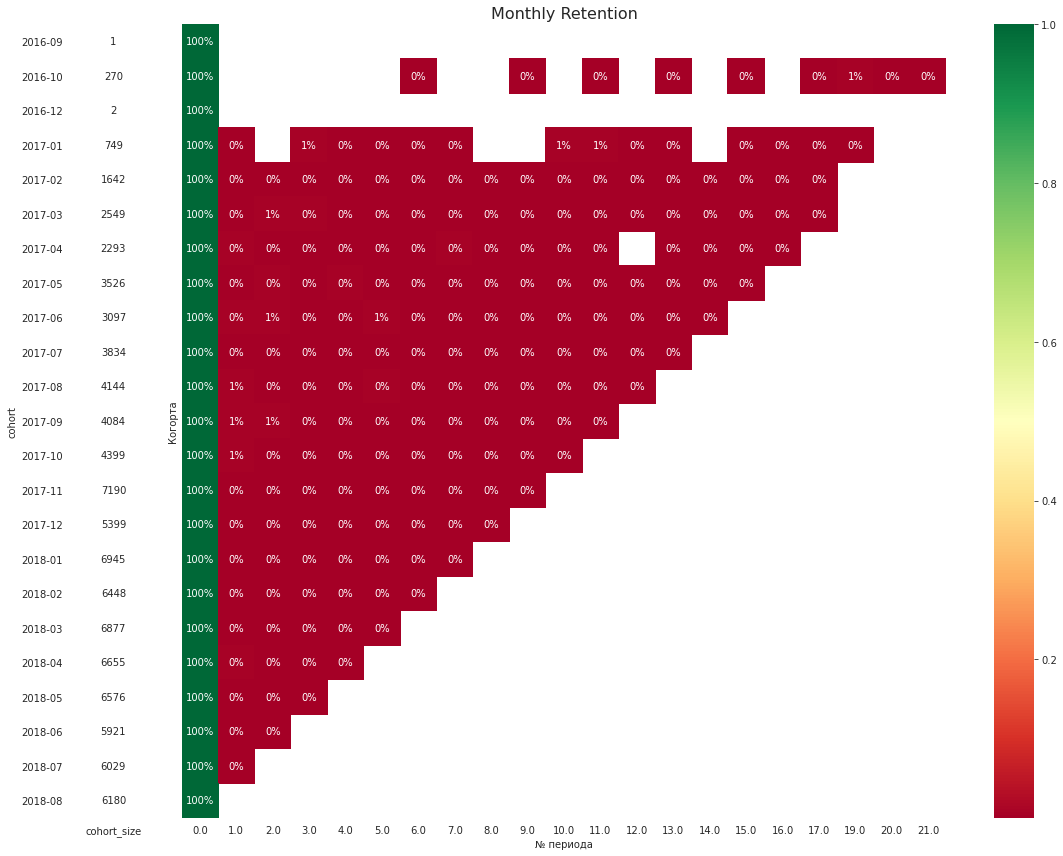

In [19]:
# Строим тепловую карту когортного анализа
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(16, 12), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    # Тепловая карта для коэффициентов удержания
    sns.heatmap(retention_matrix,
                mask=retention_matrix.isnull(),
                annot=True,
                fmt='.0%',
                cmap='RdYlGn',
                ax=ax[1])
    ax[1].set_title('Monthly Retention', fontsize=16)
    ax[1].set(xlabel='№ периода', ylabel='Когорта')

    # Тепловая карта для размеров когорт
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
                annot=True,
                cbar=False,
                fmt='g',
                cmap=white_cmap,
                ax=ax[0])

    fig.tight_layout()
    plt.show()